# Avaliação 02 - Intaligência Artificial

**Aluno:** João Victor Alcoforado de Araújo  
**Matrícula:** 20180083830

#### DEPENDÊNCIAS E AMBIENTE

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.ensemble import RandomForestClassifier
import scipy.cluster.hierarchy as sch
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras

In [ ]:
%matplotlib inline

In [ ]:
pd.options.display.float_format = "{:.2f}".format

## 1. Utilizando a base de dados de [Churn Modelling](https://www.kaggle.com/shrutimechlearn/churn-modelling/version/1), elabore uma solução para identificar se o cliente deixou o banco ou se sua conta ainda está ativa. Lembre-se de comentar seu código no notebook detalhadamente, explicando cada passo.


In [ ]:
churn_path = 'https://raw.githubusercontent.com/joaovictor42/IA/main/Churn_Modelling.csv'
churn = pd.read_csv(churn_path)

In [ ]:
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### I. Faça o pré-processamento dos dados (limpeza, engenharia de variáveis, etc) e deixe os seus dados preparados para aplicar o modelo.

OBS: Crie, pelo menos, uma  nova variável e explique o seu raciocínio.

### II. Faça uma breve análise exploratória dos dados, utilizando pelo menos dois gráficos.

**Análise de Dados Duplicados**

In [ ]:
churn.shape

(10000, 14)

In [ ]:
churn.drop_duplicates(subset=['CustomerId']).shape

(10000, 14)

Nenhum dado duplicado encontrado!

**Feature Selection**

Os atributos abaixo foram removidos de imediato do dataset por não fornecerem informações úteis à classificação.

In [ ]:
churn = churn.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

Inicialmente, os atributos abaixo foram considerados como úteis à classificação. Entretanto, após serem submetidos à técnica **Backward Elimination**, verificou-se que esses atributos não proporcionavam ganho de classificação aos modelos criados.

In [ ]:
churn = churn.drop(columns=['Geography', 'Gender'])

**Análise de Nulos**

In [ ]:
churn.isnull().sum()

CreditScore        0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

**Feature Engineering**

A nova variável "BalanceOverSalary" relaciona o saldo no banco com o suposto salário do cliente. Diante dessa perpectiva, o mais importante ao se avaliar o perfil de um cliente não é necessariamente o seu saldo, mas o seu saldo em relação ao seu sálario.


In [ ]:
churn.insert(churn.shape[1] - 1, "BalanceOverSalary", churn['Balance'] / churn['EstimatedSalary'])

**Análise de Tipos**

In [ ]:
churn.dtypes

CreditScore            int64
Age                    int64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
BalanceOverSalary    float64
Exited                 int64
dtype: object

Considerou-se que representar "Balance", "EstimatedSalary" e "BalanceOverSalary" como números decimais não proporciona ganho de informação e poderia introduzir maior complexidade aos modelos construídos.


In [ ]:
# Trucamento de atributos decimais
dtypes = {'Balance': int, 'EstimatedSalary': int, 'BalanceOverSalary': int}
churn = churn.astype(dtypes)

**Resumo Estatístico dos Atributos**

In [ ]:
churn.describe() 

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceOverSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,650.53,38.92,5.01,76485.57,1.53,0.71,0.52,100089.75,3.53,0.20
std,96.65,10.49,2.89,62397.19,0.58,0.46,0.50,57510.49,108.33,0.40
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.00,0.00,0.00
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51001.75,0.00,0.00
50%,652.00,37.00,5.00,97198.00,1.00,1.00,1.00,100193.50,0.00,0.00
75%,718.00,44.00,7.00,127643.75,2.00,1.00,1.00,149387.75,1.00,0.00
max,850.00,92.00,10.00,250898.00,4.00,1.00,1.00,199992.00,10614.00,1.00


**Distribuição das Classes por Idade**

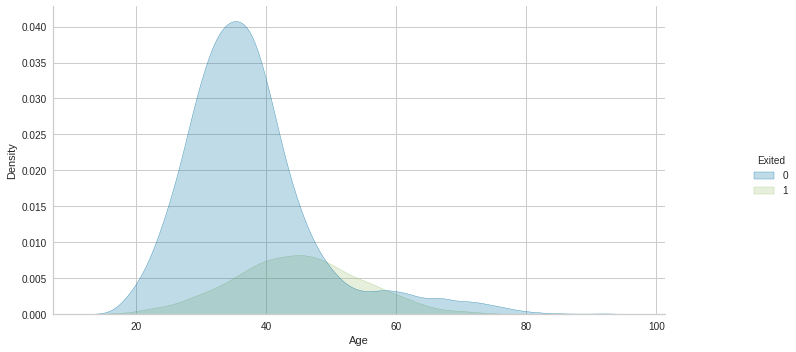

In [ ]:
graph = sns.displot(churn, x='Age', hue='Exited', kind="kde", fill=True)
graph.fig.set_size_inches(12,5)
plt.show()

**Distribuição das Classes por Saldo**

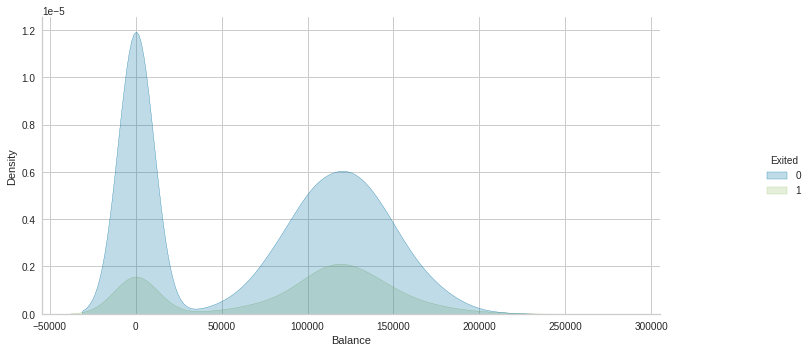

In [ ]:

graph = sns.displot(churn, x='Balance', hue='Exited', kind="kde", fill=True)
graph.fig.set_size_inches(12,5)
plt.show()

**Distribuição das Classes por Numéro de Produtos**

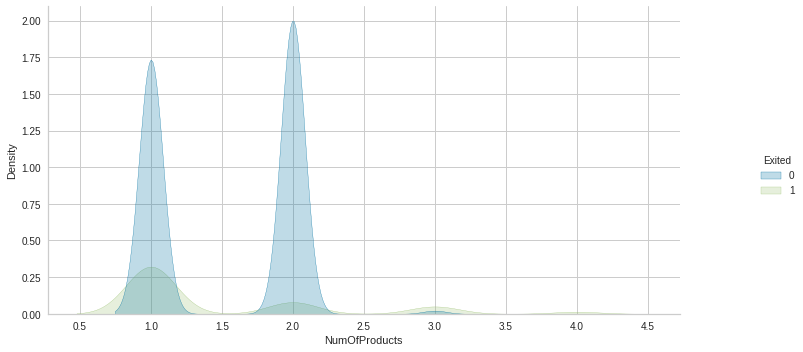

In [ ]:
graph = sns.displot(churn, x='NumOfProducts', hue='Exited', kind="kde", fill=True)
graph.fig.set_size_inches(12,5)
plt.show()

**Correlação Entre os Atributos**

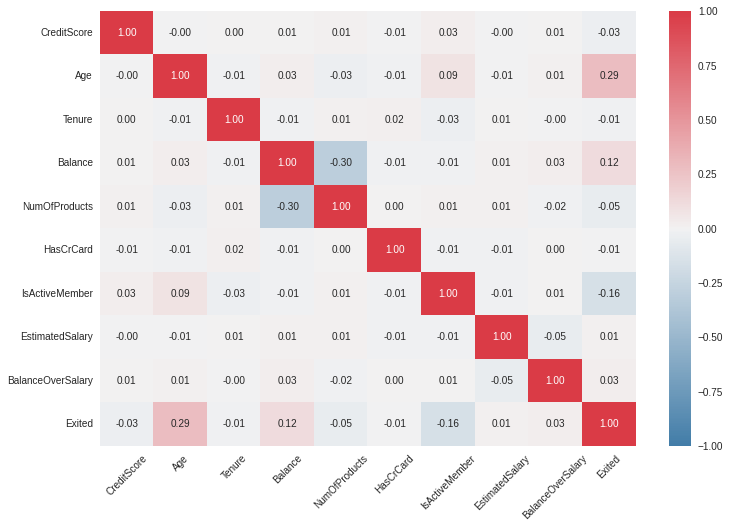

In [ ]:
plt.figure(figsize=(12, 8))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(churn.corr(), cmap=cmap, annot=True, fmt= '.2f', vmin=-1, vmax=1)
plt.xticks(rotation=45)
plt.show()

No geral todas as variáveis apresentam correlação fraca. Vale ressaltar, como justificativa para essa evidência, que a maioria das variáveis são númericas, mas expressam categorias.

**Balanceamento das Classes Alvo**

In [ ]:
churn['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Classes alvo estão desbalanceadas, o que pode induzir vieses ao modelo. Para tanto, as classes devem ser adequadamente balanceadas.  

**Downsampling**

In [ ]:
# Serparação das classes minoritárias e majoritárias
churn_majority = churn[churn['Exited'] == 0]
churn_minority = churn[churn['Exited'] == 1]

# Tamanho da classe minoritária
minority_lenght = churn_minority.shape[0]

# Downsample da classe majoritária
majority_resampled = resample(
    churn_majority, 
    replace=False, # Downsampling sem reposição
    n_samples=minority_lenght, 
    random_state=42 # Seed 
) 
 
# Formação do dataset balanceado
churn_balanced = pd.concat([majority_resampled, churn_minority])

In [ ]:
# Visualização do novo balanceamento
churn_balanced['Exited'].value_counts()

1    2037
0    2037
Name: Exited, dtype: int64

In [ ]:
churn_balanced.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceOverSalary,Exited
8165,606,37,8,154712,2,1,0,89099,1,0
6409,683,33,9,0,2,1,1,38784,0,0
2157,744,44,3,0,2,1,1,189016,0,0
1618,697,27,8,141223,2,1,0,90591,1,0
1633,562,35,7,0,1,0,0,48869,0,0


**Preparação dos Dados Para Modelos de Machine Learning**

In [ ]:
# Separação variáveis independentes e dependentes
X = churn_balanced.iloc[:, :-1].values
y = churn_balanced.iloc[:, -1].values

# Devisão dos dados em teste e treino estratificado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalização dos dados
standard_scaler = StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

### III. Escolha dois modelos de classificação para fazer a previsão de churn. Para cada algoritmo, faça ajustes em 2 hiperparâmetros.


### IV. Para avaliar os resultados, utilize e explique a matriz de confusão. Além disso, escolha uma outra métrica de sua preferência e o que o seu resultado significa.


**Métricas Escolhidas**  
Os resultados de classificação dos modelos serão avaliados a partir da acurácia, pois o dataset está balanceado. Ademais, também discutirei sobre as métricas precision e recall, que fornecem interpretações complementares sobre da matriz de confusão. 

**Matriz de Confusão**  
A matriz de confusão apresenta como o modelo classificou cada classe. Assim, torna-se trivial indentificar quais classes o modelo apresenta mais dificuldade em classificar. Além disso, em um cenário multiclasse, quais classes os modelo tem dificuldade em distinguir.

#### RANDOM FOREST

In [ ]:
random_forest_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 80)
random_forest_classifier.fit(X_train, y_train)
y_pred = random_forest_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[328  80]
 [117 290]]
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       408
           1       0.78      0.71      0.75       407

    accuracy                           0.76       815
   macro avg       0.76      0.76      0.76       815
weighted avg       0.76      0.76      0.76       815



**Acurácia**  
Considerando a complexidade do problema, 0.76 de acurácia demonstra ser uma boa métrica de desempenho. 0.76 de acurácia significa que o modelo conseguiu classificar corretamente 76% do dataset de teste. 

**Matriz de Confusão**  
A matriz de confusão demonstra certo balanceamento quanto a classificação das duas classes. O modelo acertou 80% da classe negativa, o que pode ser verificado a partir do recall da respectiva classe, e 71% da classe positiva. 
Assim, verifica-se que o modelo acerta mais instâncias da classe negativa, mas em contrapartida apresenta uma "precisão" menor para essa classe. Isso se deve ao "trade off" entre precision e recall. A métrica precision expressa a proporção de instâncias classificadas como de uma determinada classe que realmente pertencem a essa classe.




In [ ]:
random_forest_classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 25)
random_forest_classifier.fit(X_train, y_train)
y_pred = random_forest_classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[332  76]
 [111 296]]
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       408
           1       0.80      0.73      0.76       407

    accuracy                           0.77       815
   macro avg       0.77      0.77      0.77       815
weighted avg       0.77      0.77      0.77       815



**Ajuste de Parâmetros**  
O `Random Forest` está configurado para gerar árvores de decião a partir de diferentes subconjuntos de dados do dataset de treino. Assim, os parâmetros ajustados foram `n_estimators`, que determina a quantidade de árvores de decisão do modelo e o `random_state`. Esse parâmetro determina a semente usada para escolha aleatória do subconjuntos de dados para treinamento das árvores de decisão.

**Acurácia**  
Neste modelo, a acurácia chegou 0.77, sendo levemente melhor que o modelo anterior. Entretanto, como a variação é minima, não dá para afirmar que esse modelo é melhor que o anterior. Dessa forma, a interpretação desse resultado é apenas literal, o modelo classificou corretamente 77% do dataset de teste, pordendo significar melhor capacidade de generalização ou apenas sorte na classificação do dataset de teste.

**Matriz de Confusão**  
Sua matriz de confusão apresenta resultados ainda melhores que o modelo anterior, melhorando a classificação de ambas as classes. O modelo acertou 81% da classe negativa e 73% da classe positiva. A partir dessas metricas verifica-se uma melhora interessante na classificação da classe positiva. Além disso, verefica-se melhora na precisão de classificação de ambas as classes.


### DEEP LEARNING 

In [ ]:
tf.random.set_seed(15)

ann_classifier = keras.models.Sequential([
    keras.layers.Dense(units=9, activation='relu'), 
    keras.layers.Dense(units=6, activation='relu'),
    keras.layers.Dense(units=6, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

ann_classifier.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

ann_classifier.fit(X_train, y_train, epochs = 150, verbose=False)
y_pred = ann_classifier.predict(X_test) > 0.5

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[349  59]
 [126 281]]
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       408
           1       0.83      0.69      0.75       407

    accuracy                           0.77       815
   macro avg       0.78      0.77      0.77       815
weighted avg       0.78      0.77      0.77       815



Como o dataset alvo é muito complexo, optou-se por um modelo mais robusto para classifição dos dados.

**Acurácia**    
A acurácia foi igual ao melhor modelo Random Forest.  

**Matriz de Confusão**  
Entretanto, apesar de apresentarem mesma acurácia, suas matrizes de confusão são bem diferentes. A partir da matriz de confusão pode-se verificar que a classificão melhorou para a classe negativa, mas piorou significamente para a classe positiva.  



In [ ]:
tf.random.set_seed(15)

ann_classifier = keras.models.Sequential([
    keras.layers.Dense(units=9, activation='sigmoid'), 
    keras.layers.Dense(units=6, activation='sigmoid'),
    keras.layers.Dense(units=6, activation='sigmoid'),
    keras.layers.Dense(units=6, activation='sigmoid'),
    keras.layers.Dense(units=6, activation='sigmoid'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)


ann_classifier.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

ann_classifier.fit(X_train, y_train, epochs = 150, verbose=False)
y_pred = ann_classifier.predict(X_test) > 0.5

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[333  75]
 [107 300]]
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       408
           1       0.80      0.74      0.77       407

    accuracy                           0.78       815
   macro avg       0.78      0.78      0.78       815
weighted avg       0.78      0.78      0.78       815



**Ajuste de Parâmetros**  
Os parâmetros ajustados foram a (i) a quantidade camadas ocultas e (ii) as suas respectivas funções de ativação das camadas.

**Acurácia**    
O respectivo modelo acertou 78% do dataset de teste, apresentando a melhor acurácia dentre os modelos analisados.

**Matriz de Confusão**  
A partir da matriz de confusão verifica-se que a classificação melhorou para ambas as classes, o que também pode ser verificado a partir dos valores de recall. Dessa forma, considerando as metricas analisadas, esse foi o melhor classificador treinado. 

### 3. Utilize este [dataset](https://www.kaggle.com/akram24/mall-customers), que trata de informações de clientes de um shopping.  

Diante disso: 

I. Com seu conhecimento sobre os algoritmos de agrupamento, execute o K-means e Hierárquico.

II. Altere a quantidade de clusters para 3 valores de sua escolha.

III. Na execução do Hierárquico, varie 2 métodos do linkage.

IV. Compare os resultados das execuções anteriores e adote uma medida de avaliação própria para clusterização. 



#### FUNÇÕES AUXILIARES

In [ ]:
def visualize_cluters(x, y, hue=None):
    """Scatterplot Annual Income (k$) x relação ao Spending Score (1-100)"""

    plt.figure(figsize=(10,6))
    sns.scatterplot(x=x, y=y, hue=hue, palette='deep')
    plt.title('Clusters of customers')
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.legend(bbox_to_anchor=(1.15, 1))
    plt.show()

#### ANÁLISE EXPLORATÓRIA

In [ ]:
mall_path = 'https://raw.githubusercontent.com/joaovictor42/IA/main/Mall_Customers.csv'
mall = pd.read_csv(mall_path)

In [ ]:
mall.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


**Distribuição dos Atributos Annual Income (k$) e Spending Score (1-100)**

No handles with labels found to put in legend.


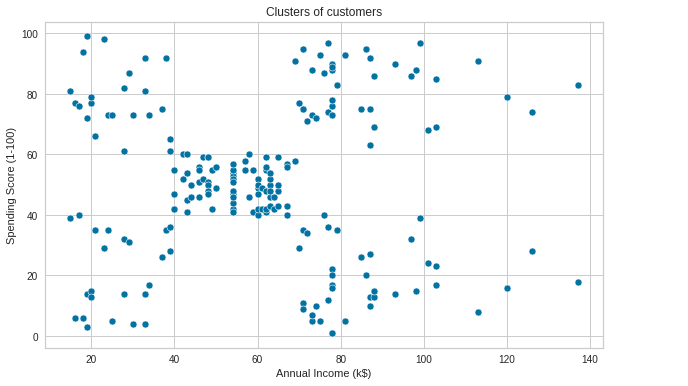

In [ ]:
visualize_cluters(mall['Annual Income (k$)'], mall['Spending Score (1-100)'])

**Preparação dos Dados Para Clusterização**

In [ ]:
X = mall[['Annual Income (k$)', 'Spending Score (1-100)']].values

#### K-MEANS

**Seleção da Quantidade de Clusters**

O método Elbow é usado para determinar o número ideal de clusters no agrupamento k-means. Claro que o número de clusters depende muito do problema e da intenção do especialista. Diante disso, o Elbow pode contribuir para visualização da formação de grupos usando k-means, uma vez que o `distortion score` representa média das distâncias ao quadrado das instâncias do cluster em relação ao seu centróide. Assim, a partir do `distortion score` pode-se ter uma noção do quão bem definidos os cluters são os cluters formados em cada agrupamento.


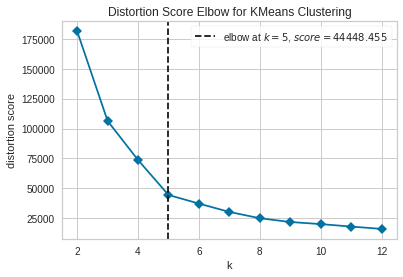

In [ ]:
visualizer = KElbowVisualizer(KMeans(), k=12, timings=False)
visualizer.fit(X)       
visualizer.show()       

A partir do gráfico, foram escolhidos para análise de agrupamento as seguintes quantidade de clusters: 5, 4 e 3.

**Execução KMeans - 5 Clusters**

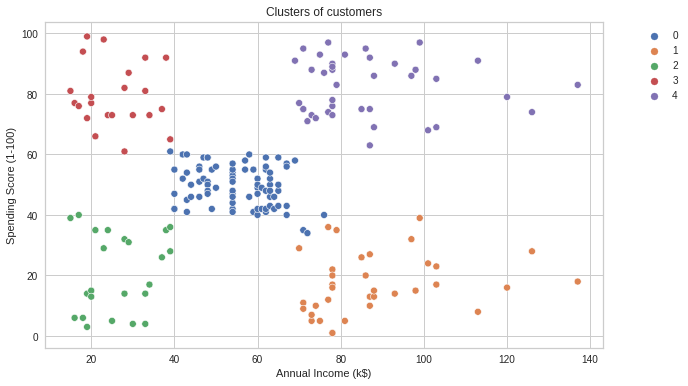

In [ ]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
clusters = kmeans.fit_predict(X)
visualize_cluters(X[:, 0], X[:, 1], hue=clusters)

**Execução KMeans - 4 Clusters**

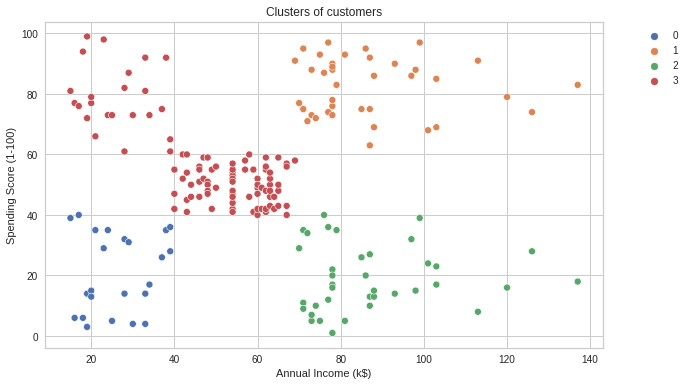

In [ ]:
kmeans = KMeans(n_clusters = 4, random_state = 42)
clusters = kmeans.fit_predict(X)
visualize_cluters(X[:, 0], X[:, 1], hue=clusters)

**Execução KMeans - 3 Clusters**

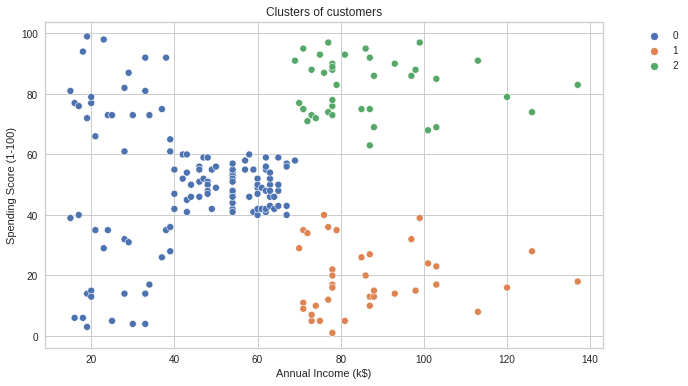

In [ ]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
clusters = kmeans.fit_predict(X)
visualize_cluters(X[:, 0], X[:, 1], hue=clusters)

#### HIERARCHICAL CLUSTERING

**Execução Hierarchical - 5 Clusters - Single Linkage**

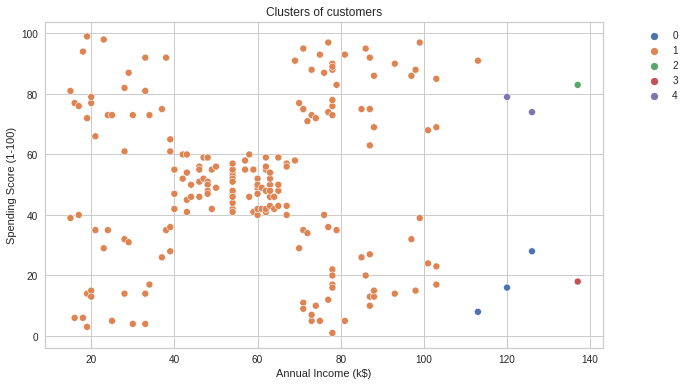

In [ ]:
hierarchical = AgglomerativeClustering(n_clusters = 5, linkage = 'single')
clusters = hierarchical.fit_predict(X)
visualize_cluters(X[:, 0], X[:, 1], hue=clusters)

**Execução Hierarchical - 5 Clusters - Complete Linkage**

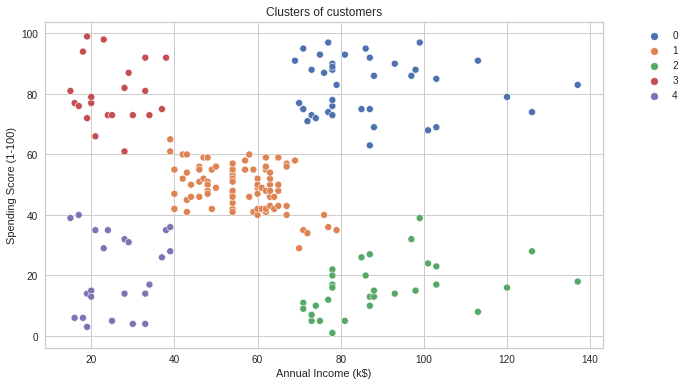

In [ ]:
hierarchical = AgglomerativeClustering(n_clusters = 5, linkage = 'complete')
clusters = hierarchical.fit_predict(X)
visualize_cluters(X[:, 0], X[:, 1], hue=clusters)

**Comparação dos Resultados**

Para avaliação dos cluters formados considerou-se: (i) formação de grupos com perfis de score de compra e pode de compra similares, e (ii) possibilidade de comparar cluters com poderes de compra similar, mas com diferentes score de compra. 

Considerando esses aspectos, o agrupamento k-means com 5 clusters formou clusters com perfis mais parecidos, contemplando o critério (i). Além disso, verifica-se que os clusters 2 e 3 apresentam poder de compara similar, mas diferentes scores de compara. Os clusters 1 e 4 apresentam poder de compara similar, mas diferentes scores de compara, assim contemplando o critério (ii). Dessa forma, verficia-se a existência de 5 grupos de clientes bem definidos e também clientes com poder de compra similares, mas consumos opostos. 

Considerou-se agrupamentos com menos de 5 clusters não formaram agrupamentos bem definidos de clientes, apresentando alta variência de clientes de um mesmo grupo.

O hierarchical clustering com single linkage, agrupou praticamente todos as instâncias em um único cluster, colocando pontos isolados em outros. Essa formação de clusters mais alongados é caracteristico desse método, mas neste caso não se adequou ao problema. 

Por fim, o hierarchical clustering com complete linkage apresentou resultado similar ao melhor k-means. Entranto, seus grupos foram mais espaçados que os grupos formados pelo respectivo k-means. 
